In [1]:
import sys
import os
import imp
import pickle as pickle
import numpy as np

from optparse import OptionParser
from demos.diffusion import ContaminantTransportModel
from collections import Iterable
from paper.examples.diffusion_common import *
from vuq import *

In [2]:
def make_model():
    num_dim = 3

    log_prior = PDFCollection([UniformND(2),
                               MultivariateNormal([[-1.]])])
    y = load_diffusion_data()
    solver = ContaminantTransportModel()
    log_like = IsotropicGaussianLikelihood(y, solver)
    log_p = Joint(log_like, log_prior)

    return locals()

In [3]:
def parse_expr_callback(option, opt, value, parser):
    if value is not None:
        setattr(parser.values, option.dest, eval(value))


def parse_list_callback(option, opt, value, parser):
    if value is not None:
        value = [float(x) for x in value.split(',')]
        if len(value) == 0:
            value = value[0] 
    setattr(parser.values, option.dest, value)


def initialize_bounds(l, u, n):
    def convert_to_list(l, n):
    if not isinstance(l, Iterable):
        l = [l] * n
    return l
    l = convert_to_list(l, n)
    u = convert_to_list(u, n)
    b = tuple((l[i], u[i]) for i in range(n))
    return b


def main(options):
    """
    The main function.
    """
    # Load the model
    model = options.model#initialize_native_model(options.model)
    # Get the target
    log_p = model['log_p']
    # Get the prior
    log_prior = model['log_prior']
    # Construct the initial approximation
    comp = [MultivariateNormal(log_prior.sample().flatten())
            for i in range(options.num_comp)]
    log_q = MixtureOfMultivariateNormals(comp)
    if options.mu_init is not None:
        log_q.mu = options.mu_init
        print (str(log_q))
    # The entropy approximation
    entropy = eval(options.entropy_approximation + '()')
    # The expectation functional
    expectation_functional = eval(options.expectation_functional + '(log_p)')
    # The Evidence-Lower-BOund
    elbo = EvidenceLowerBound(entropy, expectation_functional)
    # The optimizer
    optimizer = Optimizer(elbo)
    # The upper and lower bounds for everything
    mu_bounds = initialize_bounds(options.mu_lower_bound, options.mu_upper_bound, log_q.num_dim)
    C_bounds = initialize_bounds(options.C_lower_bound, options.C_upper_bound, log_q.num_dim)
    print ('mu_bounds', mu_bounds)
    print ('C_bounds', C_bounds)
    # The output file
    output_file = options.output
    if output_file is None:
        output_file = os.path.abspath('4_corners_num_comp=' + str(options.num_comp) + '.pcl')
    # Delete the output file if it exists and you want to force calculations
    if os.path.exists(output_file) and options.force:
        print ('-', output_file, 'exists')
        print ('- I am removing it')
        os.remove(output_file)
    # If the file exists at this point, then this is not a forced calculation
    # and we should just load it
    if os.path.exists(output_file):
        print ('- I am not repeating the calculations')
        with open(output_file, 'rb') as fd:
            results = pickle.load(fd)
            L = results['L']
            log_q = results['log_q']
            nfev = results['nfev']
    else:
        # Do the optimization
        L, nfev = optimizer.optimize(log_q,
                                     tol=options.tol,
                                     max_it=options.max_it,
                                     mu_bounds=mu_bounds,
                                     C_bounds=C_bounds,
                                     full_mu=options.optimize_full_mu)
        print (str(elbo))
        # Save the results
        results = {}
        results['L'] = L
        results['log_q'] = log_q
        results['nfev'] = nfev
        with open(output_file, 'wb') as fd:
            pickle.dump(results, fd, protocol=pickle.HIGHEST_PROTOCOL)
    # Print a salary of the statistics
    w = log_q.w
    mu = log_q.mu
    C = log_q.C
    c = np.vstack([np.diag(C[i, :, :]) for i in range(log_q.num_comp)])
    x_m = np.mean(w * mu, axis=0)
    # The variance of the mixture can only be approximated via sampling...
    samples = log_q.sample(options.std_samples)
    x_s = np.std(samples, axis=0)
    x_05 = np.percentile(samples, 5, axis=0)
    x_95 = np.percentile(samples, 95, axis=0)
    print ('{0:10s} {1:10s} {2:10s}'.format('Parameter', 'Mean', 'Std.'))
    print ('-' * 32)
    for i in range(log_q.num_dim):
        print ('{0:10s} {1:4.6f} +-{2:2.6f}'.format('x_' + str(i+1), x_m[i], 1.96 * x_s[i]))
    for i in range(log_q.num_dim):
        print ('(%1.3f, %1.3f)' % (x_05[i], x_95[i]))
    print ('Number of evaluations:', nfev)

In [4]:
def initialize_model(model_file, model_name='Model', comm=None):
    rank, size = get_rank_size(comm)
    print_once('Initializing the %s.\n' % model_name, comm=comm)
    print_once('-------------------------\n', comm=comm)
    for i in range(size):
        if rank == i:
            try:
                model = imp.load_source('', model_file)
            except Exception as e:
                signal_fatal_error('I couldn\'t load the %s.\n' % model_name,
                                   comm=comm, e=e)
            print_rank(i, 'initialized %s.\n' % model_name)
        mpi_wait(comm)
    print_once('Done.\n'
               '-------------------------\n', comm=comm)
    return model


def initialize_native_model(model_file, model_name='Native Model', comm=None):
    return initialize_model(model_file, model_name=model_name, comm=comm).make_model()

In [5]:
parser = OptionParser()
parser.add_option('-m', '--model', metavar='FILE', dest='model', default=make_model(),
                  help='specify the file containing the native model')
parser.add_option('--entropy-approximation', type=str, dest='entropy_approximation',
                  default='FirstOrderEntropyApproximation',
                  help='specify the entropy approximation to be used')
parser.add_option('--expectation-functional', type=str, dest='expectation_functional',
                  default='ThirdOrderExpectationFunctional',
                  help='specify the expectation functional to be used')
parser.add_option('--num-comp', type=int, dest='num_comp', default=2,
                  help='specify the number of components that you want to use')
parser.add_option('--mu-lower-bound', type=str, dest='mu_lower_bound', default=[0]*2 + [None], action='callback',
                  callback=parse_expr_callback,
                  help='specify the lower bound for mu')
parser.add_option('--mu-upper-bound', type=str, dest='mu_upper_bound', default=[1]*2 + [None], action='callback',
                  callback=parse_expr_callback, 
                  help='specify the upper bound for mu') 
parser.add_option('--C-lower-bound', type=str, dest='C_lower_bound', action='callback',
                  callback=parse_expr_callback, default=1e-6,
                  help='specify the lower bound for C')
parser.add_option('--C-upper-bound', type=str, dest='C_upper_bound', action='callback',
                  callback=parse_expr_callback, default=[10]*3,
                  help='specify the upper bound for C')
parser.add_option('--max-it', type=int, dest='max_it', default=30,
                  help='specify the maximum number of iterations')
parser.add_option('--tol', type=float, dest='tol', default=1e-2,
                  help='specify the tolerance')
parser.add_option('--std-samples', type=int, dest='std_samples', default=1000,
                  help='specify the number of samples used in the estimation of the std')
parser.add_option('--optimize-full-mu', action='store_true', dest='optimize_full_mu',
                  help='optimize all the mus simultaneously')
parser.add_option('-f', '--force', action='store_true', dest='force',
                  help='force the calculation')
parser.add_option('-o', '--output', metavar='FILE', dest='output',
                  help='specify the output file')
parser.add_option('--mu-init', type=str, dest='mu_init', action='callback',
                  callback=parse_expr_callback,
                  help='specify the initial point for mu num_comp x num_dim')
options, args = parser.parse_args()
main(options)

mu_bounds ((0, 1), (0, 1), (None, None))
C_bounds ((1e-06, 10), (1e-06, 10), (1e-06, 10))
mu [ 0.39031276  0.84204787 -0.20245273]
mu [ 0.45940382  0.74662521 -1.19548895]
mu [ 0.41590616  0.80670044 -0.57030324]
mu [ 0.4902554  0.4684219 -0.819489 ]
mu [ 0.55924658  0.         -1.10126657]
mu [ 0.51861227  0.27589034 -0.93530569]
mu [ 0.48834681  0.11241833 -0.94244919]
mu [ 0.18067076  0.         -1.27749306]
mu [  0.           0.         -28.72324178]
mu [  0.12145821   0.         -10.27248854]
mu [ 0.16224235  0.         -4.07695849]
mu [ 0.17620003  0.         -1.95664298]
mu [ 0.17917     0.         -1.50547389]
mu [   0.            0.         -138.51396149]
mu [  0.11966101   0.         -47.01106597]
mu [  0.15955877   0.         -16.50187468]
mu [ 0.17286899  0.         -6.32375713]
mu [ 0.17734762  0.         -2.89902096]
mu [ 0.1789996   0.         -1.63577928]
mu [ 0.17916508  0.         -1.50923656]
mu [   0.            0.         -136.81851945]
mu [  0.11966037   0.       

mu [ 0.06539045  0.22363295 -2.90453167]
      fun: -12.976623068484205
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.69039371e-06,  6.07273331e-05, -3.72192197e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
   status: 0
  success: True
        x: array([ 0.06539045,  0.22363295, -2.90453167])
c: [6.22794665e-05 4.07719780e-05 2.35793342e-02]
c: [1.00000000e-06 4.80298999e-03 2.35810317e-02]
c: [6.22794582e-05 4.07726272e-05 2.35793342e-02]
c: [6.22794663e-05 4.07719941e-05 2.35793342e-02]
      fun: -11.476622875415366
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.83362463e-03,  8.81894484e-05, -1.69752046e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([6.22794663e-05, 4.07719941e-05, 2.35793342e-02])
2 11.476622875415366 -2.690917604297738e-07
Converged ***
Name: Evidence Lower Bound
E

# Graphs

In [9]:
from optparse import OptionParser
from paper.examples.diffusion_common import *
from paper.examples import diffusion_model
import matplotlib.pyplot as plt
import pickle as pickle
import tables as tb
import pandas as pd
from scipy import stats
from vuq import MultivariateNormal, MixtureOfMultivariateNormals


def main(options):
    """
    The main function.
    """
    # DATA AND MODEL
    data = load_diffusion_data()
    model = diffusion_model.make_model()
    model = model['solver']
    
    # VARIATIONAL PLOTS
    with open(options.var_file, 'rb') as fd:
        var_results = pickle.load(fd)
    log_q = var_results['log_q']

    #f = tb.open_file(options.mcmc_file, mode='r')
    #chain = options.chain
    #if chain is None:
    #    chain_counter = f.get_node('/mcmc/chain_counter')
    #    chain = chain_counter[-1][-1]
    #chain_data = getattr(f.root.mcmc.data, chain)
    #mcmc_step = chain_data.cols.step[:]
    #omega = chain_data.cols.params[:]
    #x = omega[:, :2]
    #sigma = np.exp(omega[:, 2])
    
    # Plot the histograms
    #or_omega = omega
    #omega = omega[options.skip::options.thin, :]
    #omega[:, -1] = np.exp(omega[:, -1])
    w = log_q.w
    mu =log_q.mu
    C = log_q.C
    c = np.vstack([np.diag(C[i, :, :]) for i in range(log_q.num_comp)])
    print(mu.shape[0])
    for i in range(mu.shape[0]):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #ax.hist(omega[:, i], alpha=0.5, normed=True)
        #ax.hist(smc_samples[:, i], weights=smc_weights, alpha=0.5, normed=True)
        #x_min = omega[:, i].min()
        #x_max = omega[:, i].max()
        x_i = np.linspace(x_min, x_max, 100)
        xx_i = np.log(x_i)[:, None] if i == 2 else x_i[:, None]
        # Create a 1D mixture
        comp = [MultivariateNormal([[mu[j, i]]], C=[[c[j, i]]])
                for j in range(log_q.num_comp)]
        log_q_i = MixtureOfMultivariateNormals(comp)
        y_i = np.exp(log_q_i(xx_i)) / (x_i if i == 2 else 1.)
        ax.plot(x_i, y_i, 'r-', linewidth=2)
        
        if i == 2:
            ax.plot([0.05] * 100, np.linspace(0, 50, 100), 'g--', linewidth=2)
        elif i == 0:
            ax.plot([0.09] * 100, np.linspace(0, options.max_true_pxi, 100), 'g--', linewidth=2)
        else:
            ax.plot([0.23] * 100, np.linspace(0, options.max_true_pxi, 100), 'g--', linewidth=2)
        '''
        #ax.hist(samples_var[:, i], alpha=0.5, normed=True)
        name  = '\\xi_{%d}' % (i + 1) if i < 2 else '\sigma'
        xlabel = '$' + name + '$'
        ylabel = '$p(' + name + '|y)$'
        ax.set_xlabel(xlabel, fontsize=26)
        ax.set_ylabel(ylabel, fontsize=26)
        plt.setp(ax.get_xticklabels(), fontsize=26)
        plt.setp(ax.get_yticklabels(), fontsize=26)
        if i == 0:
            leg = plt.legend(['VAR ($L=%d$)' % log_q.num_comp, 'True value', 'MCMC (MALA)'], loc='best')
            plt.setp(leg.get_texts(), fontsize=26)
        if i == 2:
            leg = plt.legend(['VAR ($L=%d$)' % log_q.num_comp, 'True noise', 'MCMC (MALA)'], loc='best')
            plt.setp(leg.get_texts(), fontsize=26)
        if i == 5:
            ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.tight_layout()
        '''
        png_file = 'result_4_corners_input_' + str(i) + '.png'
        print ('- writing', png_file)
        plt.savefig(png_file)
        del fig
    
    
    '''
    # Draw the error of MCMC as a function of the number of evaluations
    omega = or_omega[50:, :]
    mcmc_step = mcmc_step[50:]
    x_m_mcmc = np.cumsum(omega, axis=0) / np.arange(1, omega.shape[0] + 1)[:, None]
    x_m_mcmc_2 = np.cumsum(omega ** 2., axis=0) / np.arange(1, omega.shape[0] + 1)[:, None]
    x_s_mcmc = np.sqrt(x_m_mcmc_2 - x_m_mcmc ** 2.) 
    x_m_var = np.mean(mu * w[:, None], axis=0)
    samples_var = log_q.sample(options.var_samples)
    x_s_var = np.std(samples_var, axis=0)
    
    # We will compute the mean and the std of MCMC as accurately as possible
    t_m = np.mean(or_omega[700:, :], axis=0)
    t_s = np.std(or_omega[700:, :], axis=0)
    e_m = x_m_mcmc - t_m
    m_rms = np.sqrt(np.mean(e_m ** 2., axis=1)) / np.linalg.norm(t_m)
    e_s = x_s_mcmc - t_s
    s_rms = np.sqrt(np.mean(e_s ** 2., axis=1)) / np.linalg.norm(t_s)
    
    # Variational error
    v_m_rms = np.linalg.norm(mu - t_m) / np.linalg.norm(t_m)
    v_s_rms = np.linalg.norm(np.sqrt(c) - t_s) / np.linalg.norm(t_s)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mcmc_step, m_rms, '-b', linewidth=2)
    ax.plot(mcmc_step, np.ones(mcmc_step.shape[0]) * v_m_rms, '--b', linewidth=2)
    ax.plot(mcmc_step, s_rms, '.-g', linewidth=2)
    ax.plot(mcmc_step, np.ones(mcmc_step.shape[0]) * v_s_rms, ':g', linewidth=2)
    ax.set_xlim([0, 70000])
    ax.set_yscale('log')
    png_file = 'rms.png'
    plt.savefig(png_file)
    '''

1


NameError: name 'x_i' is not defined

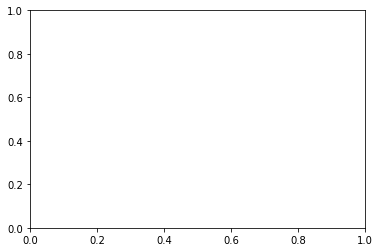

In [10]:
parser = OptionParser()
parser.add_option('--var-file', dest='var_file', metavar='FILE', 
                  default='C:\\Users\\Fedor\\Documents\\GitHub\\variational-reformulation-of-inverse-problems\\4_corners_num_comp=1.pcl',
                  help='set the variational results file')
parser.add_option('--mcmc-file', dest='mcmc_file', metavar='FILE',
                  help='set the input file (result of an MCMC simulation)')
parser.add_option('--num-samples', dest='num_samples', type=int, default=10000,
                  help='the number of samples used to compute the error bars')
parser.add_option('-f', '--force', dest='force', action='store_true',
                  help='force the calculations')
parser.add_option('-c', '--chain', type=str, dest='chain',
                  help='specify the MCMC chain you want to look at (default looks at last)')
parser.add_option('-s', '--skip', type=int, dest='skip', default=100,
                  help='the number of MCMC chain records you want to skip')
parser.add_option('--thin', type=int, dest='thin', default=1,
                  help='specify how much you want to thin the MCMC chain.')
parser.add_option('--max', type=int, dest='max', default=-1,
                  help='specify the maximum mcmc step you want to use')
parser.add_option('--var-samples', type=int, dest='var_samples', default=10000,
                  help='the number of samples used to compute the standard deviation of'
                       ' log_q')
parser.add_option('--rolling', type=int, dest='rolling', default=100,
                  help='specify the number of samples used to compute the rolling mean')
parser.add_option('--max-true-pxi', type=float, dest='max_true_pxi', default=50.,
                  help='specify the height of the vertical, green, dashed line that'
                       ' indicates the location of the true source')
options, args = parser.parse_args()
main(options)